# Multi-layer perceptron

In [1]:
## If problems arise with the loading of the shared library, this script can be used to load the shared library before other libraries.
## Remember to also run on your local machine the script below:
# bash replace_lib_version.sh

import platform
import ctypes

if platform.system() == "Linux":
    # Force libgomp to be loaded before other libraries consuming dynamic TLS (to avoid running out of STATIC_TLS)
    ctypes.cdll.LoadLibrary("libgomp.so.1")
    ctypes.cdll.LoadLibrary(
        "/home/vscode/.local/lib/python3.12/site-packages/py_nillion_client/py_nillion_client.abi3.so"
    )

In [2]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import json
import nada_numpy as na
import numpy as np
import py_nillion_client as nillion
import torch
from common.utils import store_program, store_secrets
from cosmpy.aerial.client import LedgerClient
from cosmpy.aerial.wallet import LocalWallet
from cosmpy.crypto.keypairs import PrivateKey
from dotenv import load_dotenv
from nada_ai.client import TorchClient
from nillion_python_helpers import (create_nillion_client,
                                    create_payments_config)
from py_nillion_client import NodeKey, UserKey

from torch import nn
from torchvision import transforms
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support,
)
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

home = os.getenv("HOME")
load_dotenv(f"{home}/.config/nillion/nillion-devnet.env")

/Users/mathiasleys/projects/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

### Train a Covid image classification model on CT scans

Before this step you must install kaggle

In [3]:
!kaggle datasets download mehradaria/covid19-lung-ct-scans -p data --unzip

Dataset URL: https://www.kaggle.com/datasets/mehradaria/covid19-lung-ct-scans
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
... resuming from 846200832 bytes (252214311 bytes left) ...
100%|█████████████████████████████████████▉| 1.02G/1.02G [00:31<00:00, 9.06MB/s]
100%|██████████████████████████████████████| 1.02G/1.02G [00:31<00:00, 8.05MB/s]


In [4]:
class CovidDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir: os.PathLike, transform) -> None:
        self.root_dir = root_dir
        self.transform = transform

        self.classes = ["Non-COVID-19", "COVID-19"]

        self.data = []
        self.targets = []

        for class_index, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith(".png"):
                    img_path = os.path.join(class_dir, filename)
                    self.data.append(img_path)
                    self.targets.append(class_index)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = self.data[index]
        label = self.targets[index]

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        return img, label

In [5]:
# Create custom torch Module
class MyNN(nn.Module):
    """My brand new model"""

    def __init__(self) -> None:
        """Model is a two layers and an activations"""
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=2, kernel_size=3, padding=1, stride=3
        )
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=18, out_features=2)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x: na.NadaArray) -> na.NadaArray:
        """My forward pass logic"""
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

my_model = MyNN()

In [6]:
dataset = CovidDataset(
    os.path.join("data", "COVID-19_Lung_CT_Scans"),
    transform=transforms.Compose(
        [
            transforms.Grayscale(),
            transforms.Resize((16, 16)),
            transforms.ToTensor(),
        ]
    ),
)
trainset, testset = torch.utils.data.random_split(dataset, [0.8, 0.2])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(my_model.parameters(), lr=1e-4)

In [7]:
accuracies, losses = [], []
for epoch in range(10):
    print(f"Starting epoch {epoch+1}...")

    incorrect, correct = 0, 0
    current_loss = 0
    for i, data in enumerate(trainloader):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = my_model(inputs)
        loss = loss_function(outputs, targets)

        preds = torch.argmax(outputs, axis=1)

        correct += (preds == targets).float().sum()
        incorrect += (preds != targets).float().sum()

        loss.backward()
        optimizer.step()

        current_loss += loss.item()
        if i % 100 == 99:
            accuracy = 100 * correct / (incorrect + correct)
            accuracies.append(accuracy)

            print("Loss after mini-batch %5d: %.3f" % (i + 1, current_loss / 100))
            losses.append(current_loss / 100)
            print("Accuracy after mini-batch %5d: %.3f" % (i + 1, accuracy))

            correct, incorrect = 0, 0
            current_loss = 0

Starting epoch 1...
Loss after mini-batch   100: 0.692
Accuracy after mini-batch   100: 56.812
Loss after mini-batch   200: 0.671
Accuracy after mini-batch   200: 89.125
Loss after mini-batch   300: 0.649
Accuracy after mini-batch   300: 87.812
Loss after mini-batch   400: 0.617
Accuracy after mini-batch   400: 89.062
Starting epoch 2...
Loss after mini-batch   100: 0.579
Accuracy after mini-batch   100: 87.375
Loss after mini-batch   200: 0.531
Accuracy after mini-batch   200: 89.562
Loss after mini-batch   300: 0.500
Accuracy after mini-batch   300: 87.750
Loss after mini-batch   400: 0.462
Accuracy after mini-batch   400: 88.812
Starting epoch 3...
Loss after mini-batch   100: 0.437
Accuracy after mini-batch   100: 87.250
Loss after mini-batch   200: 0.404
Accuracy after mini-batch   200: 88.375
Loss after mini-batch   300: 0.389
Accuracy after mini-batch   300: 88.875
Loss after mini-batch   400: 0.350
Accuracy after mini-batch   400: 89.875
Starting epoch 4...
Loss after mini-batc

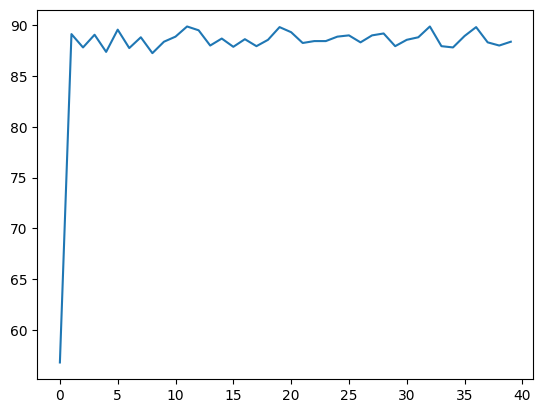

In [8]:
plt.plot(accuracies)

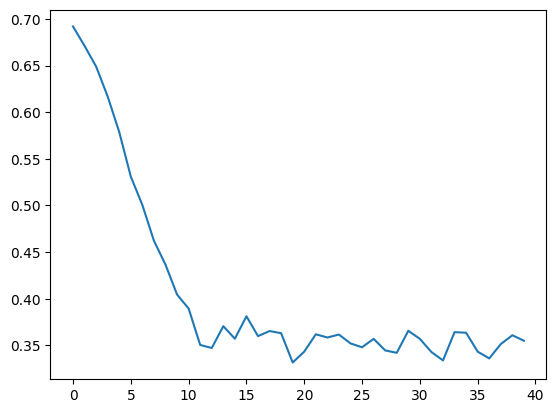

In [9]:
plt.plot(losses)

In [10]:
y_pred = []
y_true = []
for i, data in enumerate(testloader):
    inputs, targets = data

    outputs = my_model(inputs)
    preds = torch.argmax(outputs, axis=1)

    y_pred.extend(preds.tolist())
    y_true.extend(targets.tolist())

In [11]:
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
print("precision: {:.3f}%".format(precision[1] * 100))
print("recall: {:.3f}%".format(recall[1] * 100))
print("f1: {:.3f}%".format(f1[1] * 100))
print("support: {}".format(support[1]))

precision: 89.686%
recall: 100.000%
f1: 94.562%
support: 1513


/Users/mathiasleys/projects/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


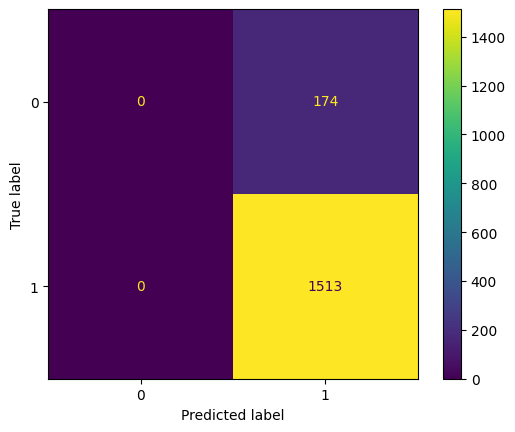

In [12]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
disp.plot()

## Model Provider flow

### Authenticate with Nillion

To connect to the Nillion network, we need to have a user key and a node key. These serve different purposes:

The `user_key` is the user's private key. The user key should never be shared publicly, as it unlocks access and permissions to secrets stored on the network.

The `node_key` is the node's private key which is run locally to connect to the network.

In [13]:
# Load all Nillion network environment variables
assert os.getcwd().endswith(
    "examples/multi_layer_perceptron"
), "Please run this script from the examples/multi_layer_perceptron directory otherwise, the rest of the tutorial may not work"
load_dotenv()

True

In [14]:
cluster_id = os.getenv("NILLION_CLUSTER_ID")
grpc_endpoint = os.getenv("NILLION_NILCHAIN_GRPC")
chain_id = os.getenv("NILLION_NILCHAIN_CHAIN_ID")
seed = "my_seed"
model_provider_userkey = UserKey.from_seed((seed))
model_provider_nodekey = NodeKey.from_seed((seed))
model_provider_client = create_nillion_client(model_provider_userkey, model_provider_nodekey)
model_provider_party_id = model_provider_client.party_id
model_provider_user_id = model_provider_client.user_id

In [15]:
party_names = ["Provider", "User"]
program_name = "multi_layer_perceptron"
program_mir_path = f"target/{program_name}.nada.bin"

In [16]:
payments_config = create_payments_config(chain_id, grpc_endpoint)
payments_client = LedgerClient(payments_config)
payments_wallet = LocalWallet(
    PrivateKey(bytes.fromhex(os.getenv("NILLION_NILCHAIN_PRIVATE_KEY_0"))),
    prefix="nillion",
)

### Upload Nada program to Nillion

TODO: explain what the Nada program does

In [17]:
program_id = await store_program(
    model_provider_client,
    payments_wallet,
    payments_client,
    model_provider_user_id,
    cluster_id,
    program_name,
    program_mir_path,
)

Getting quote for operation...
Submitting payment receipt 2 unil, tx hash 32054F2BE5EED437390CDF7A782C6659B8F0C178A398CCF346178E2827C554DB
Stored program. action_id: 3rgqxWd47e171EUwe4RXP9hm45tmoXfuF8fC52S7jcFoQTnU8wPiL7hqWzyV1muak6bEg7iWhudwg4t2pM9XnXcp/multi_layer_perceptron
Stored program_id: 3rgqxWd47e171EUwe4RXP9hm45tmoXfuF8fC52S7jcFoQTnU8wPiL7hqWzyV1muak6bEg7iWhudwg4t2pM9XnXcp/multi_layer_perceptron


### Upload weights to Nillion network

In [18]:
# Create and store model secrets via ModelClient
model_client = TorchClient(my_model)

In [19]:
model_secrets = nillion.NadaValues(
    model_client.export_state_as_secrets("my_nn", na.SecretRational)
)
permissions = nillion.Permissions.default_for_user(model_provider_client.user_id)
permissions.add_compute_permissions({model_provider_client.user_id: {program_id}})

model_store_id = await store_secrets(
    model_provider_client,
    payments_wallet,
    payments_client,
    cluster_id,
    model_secrets,
    1,
    permissions,
)

Getting quote for operation...
Quote cost is 5570 unil
Submitting payment receipt 5570 unil, tx hash 6A9CB2D7060BE85272B383A6F23E71D34B10B87D27F21173004990831868683A


In [20]:
# This information is needed by the model user
with open("data/tmp.json", "w") as provider_variables_file:
    provider_variables = {
        "program_id": program_id,
        "model_store_id": model_store_id,
        "model_provider_party_id": model_provider_party_id,
    }
    json.dump(provider_variables, provider_variables_file)

In [21]:
torch.save(my_model.state_dict(), "./data/my_model.pt")